# Project Overview

The stock market has alwaay been a sort of black box inn its performance. 
Investors have tried multiple ways to predict future prices in order to make the right investment. 
It has been an area of interest for me  not only because of the money one can make; but also the power one would have over multiple companies.

Is it possible to accurately predict stock prices? 
According to Burton Malkiel , an American economist and author; stocks have unpredictable and random behaviour, this makes all methods of prediction unreliable.
In the recent years, because of advancement in technology, multiple prediction methods have been developed among them machine learning.

In this project, I will start a journey of predicting stock prices


# Problem Statement

The main objective of this project is to predict stock prices using machine learning.

The main challenge is to allow the user to select whichever stock they are interested in as well as prediction dates.

I will build a solution that includes:
    
1. Uses stock price data from Yahoo Finance

2. Perform all machine learning steps including training multiple models, validating the models

3. A python dash dashboard that acts as a user interface to select:
    

    a. A start and end date to train a model
    
    b. A start and end date to predict
    
    c. A date to validate and see the models performance
    
    d. Number of models to explore in h2o
    
    e. Symbols to be predicted (multiple or one)
    
    The user will see:

        a. A table with the best trained models performance
        
        b. A graph with all symbol predictions



# Metrics

The method that will be used is regression and the metric of interest will be MAPE ( mean absolute percentage error).


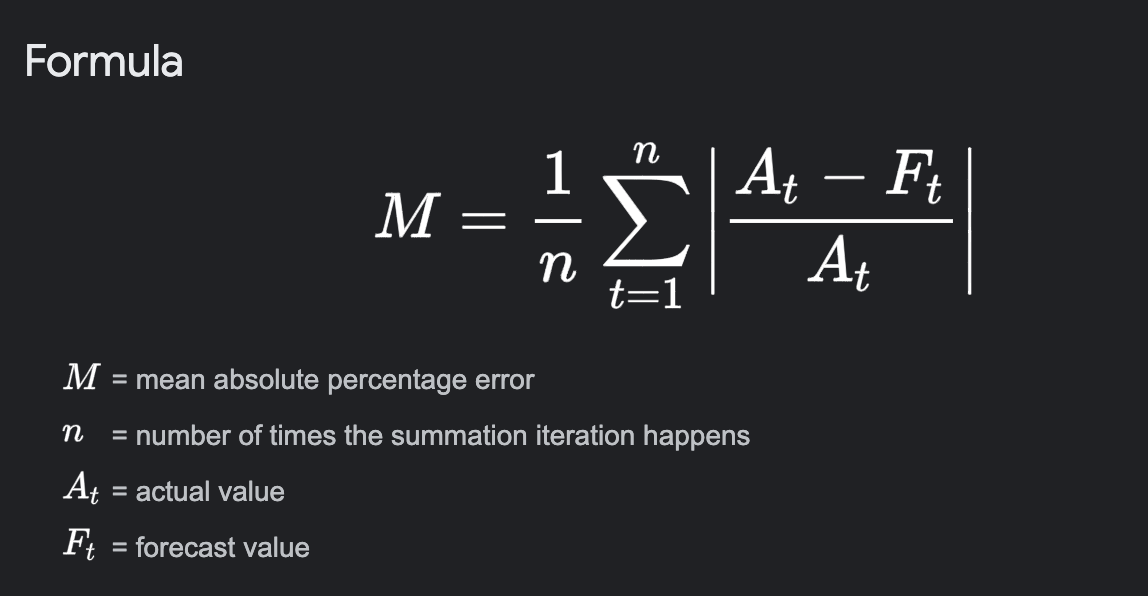




This measure is easy to understand because it provides the error in terms of percentages. 

Also, because absolute percentage errors are used, the problem of positive and negative errors canceling each other out is avoided. Consequently, MAPE is a measure commonly used in forecasting. 

The smaller the MAPE the better the forecast and the more profit we can make since we have the correct future information.




# EDA

Since we have to build a solution to predict any symbol from the stocks, we wont be able to explore all symbols, but we will use 'GS' for data exploration annd model building.

I choose 'GS' not because of any good generalization, but simply because I have history with their stocks.

We will use pandas_datareader to get the stock closing prices from Yahoo.


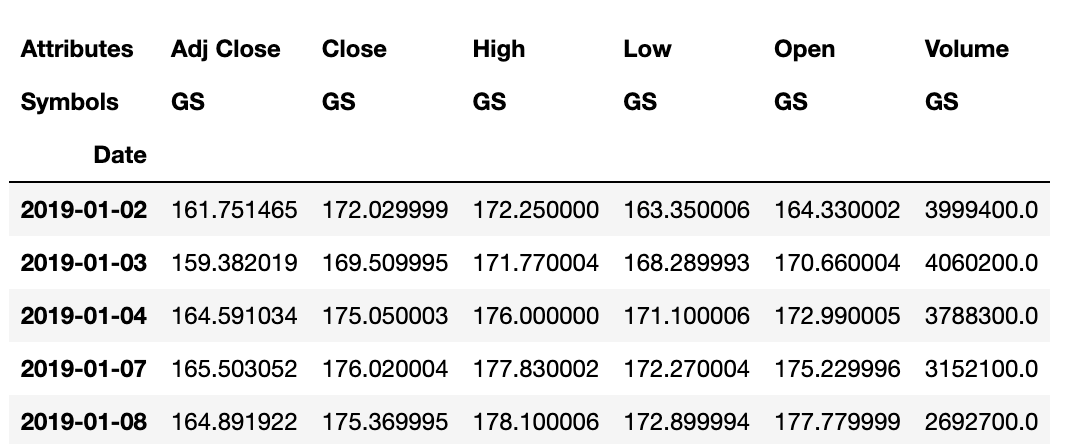





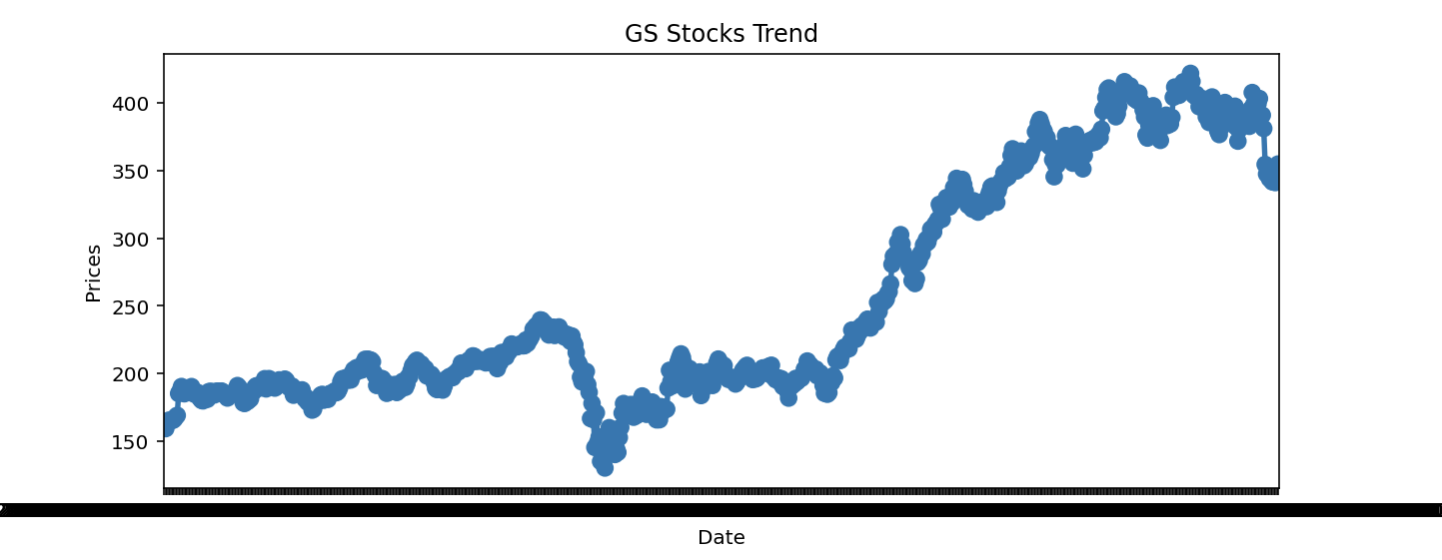


There was a dip around March 2020, this is expected because it was the start of Corona. The stock prices however started growing from then.

There is some signal in the date features because we can see clear seasonal effects as below- there is always a dip in the 4th week of every month, current years have had the biggest growths:
    
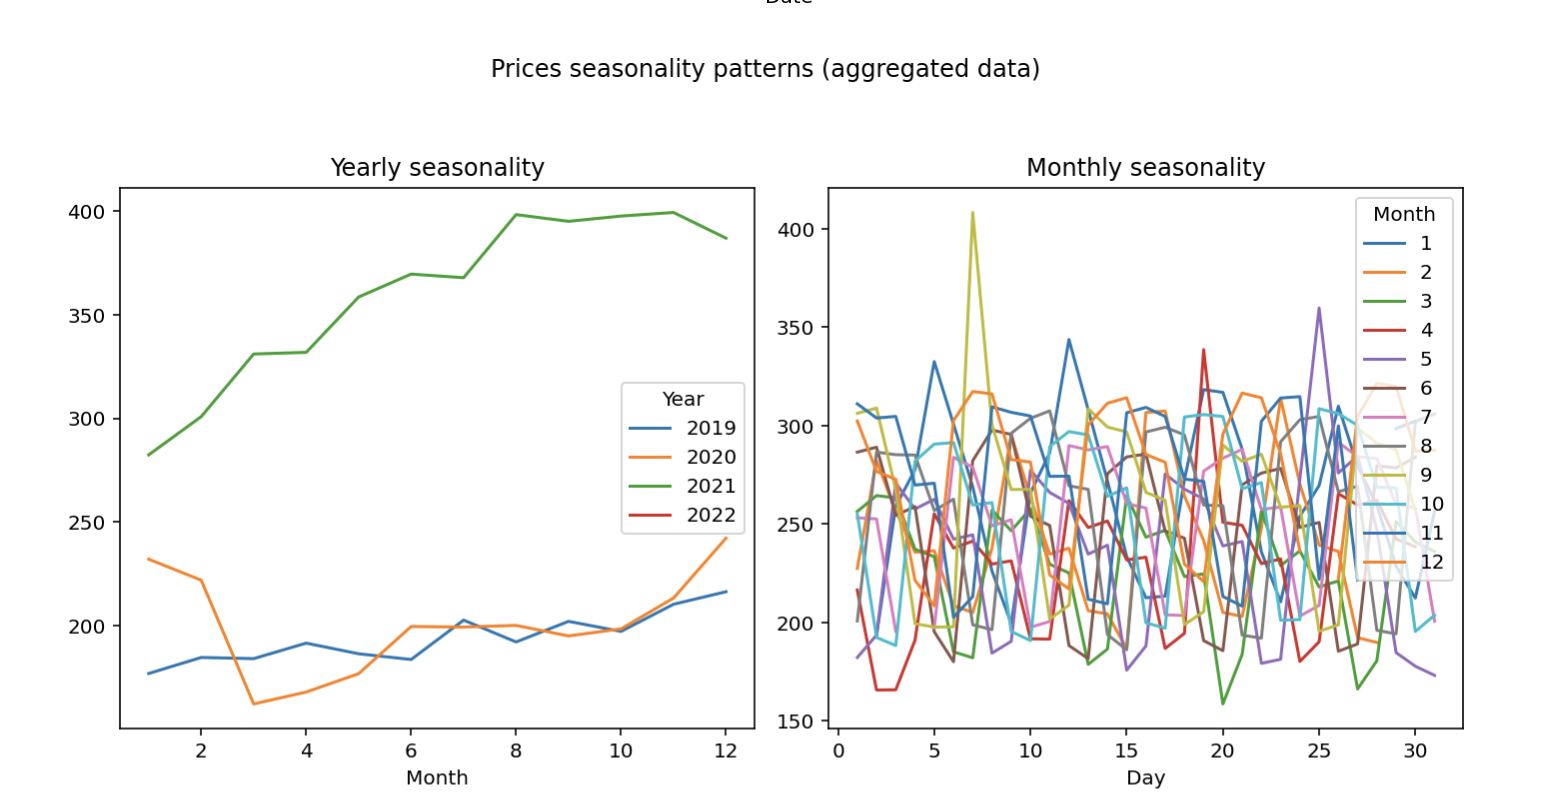

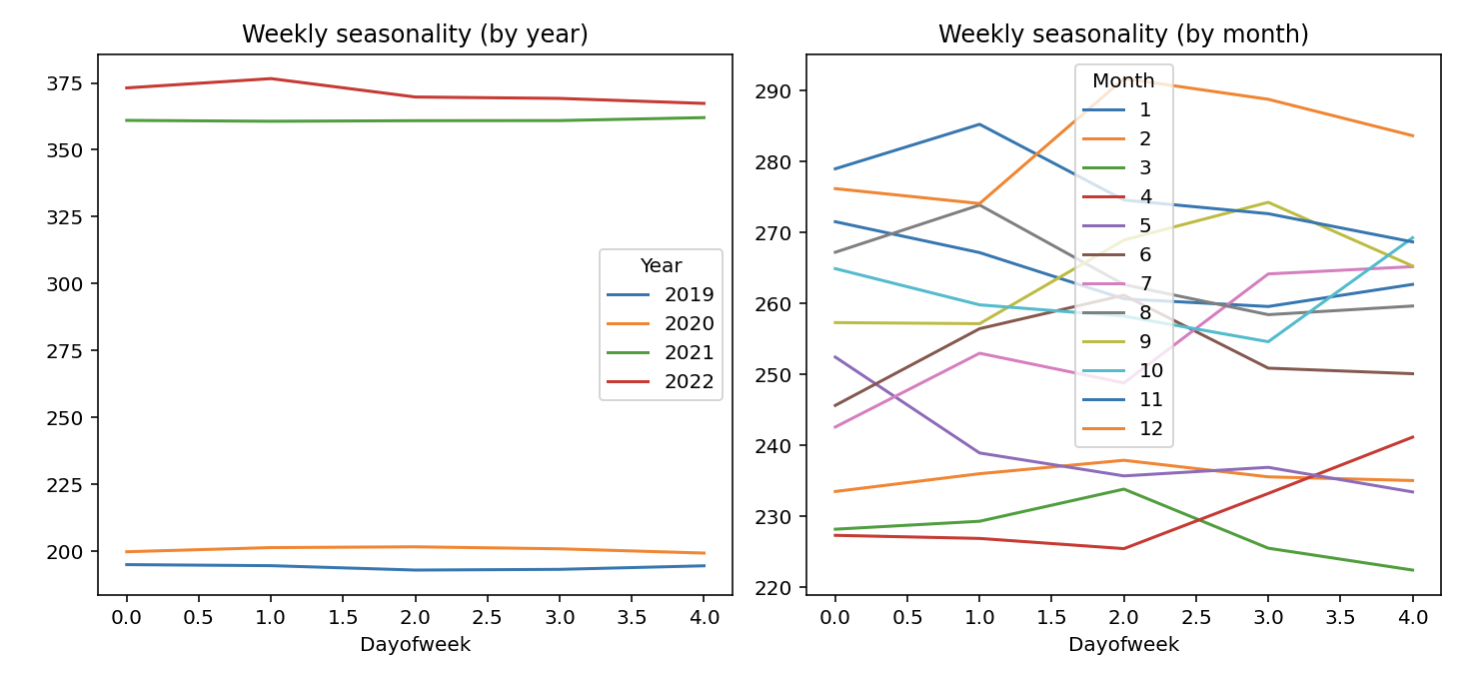

The plot below shows that the cumulative log returns for GS looks like it has hit a plateau in the recent months;

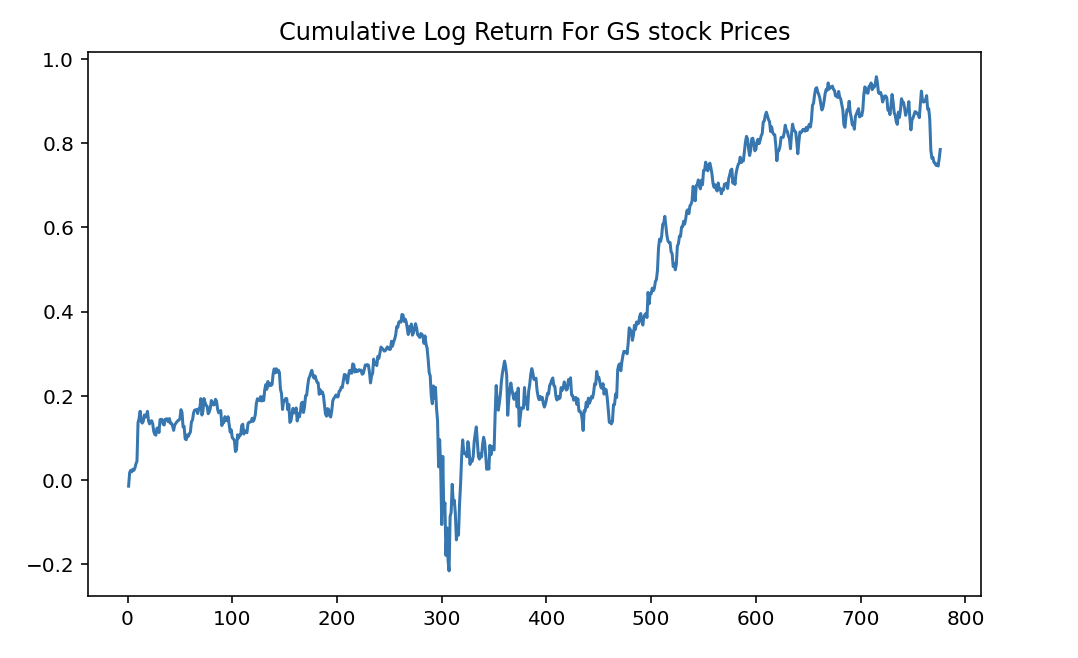

In [20]:
import re
gs_aapl_df_clean=gs_aapl_df_clean.sort_values(by='Date')
def add_datepart(df, fldname, inplace=False, drop=False):
    if not inplace: df = df.copy()        
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','Weekofyear']
#     attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','Weekofyear',
#             'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    for n in attr: 
        df[n] = getattr(fld.dt, n.lower())
    if drop: 
        df.drop(fldname, axis=1, inplace=True)
    if not inplace: return df 

df_trainext = add_datepart(gs_aapl_df_clean, 'Date', inplace=False).fillna(0)
# df_testext = add_datepart(df_test, 'date', inplace=False)
display(df_trainext.head(3))

<ipython-input-20-36790efe9298>:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[n] = getattr(fld.dt, n.lower())


Date Symbols      Prices  Log Return  cum_Log_Return  Year  Month  \
0 2019-01-02      GS  161.751450    0.000000        0.000000  2019      1   
1 2019-01-03      GS  159.382019   -0.014757       -0.014757  2019      1   
2 2019-01-04      GS  164.591034    0.032160        0.017403  2019      1   

   Week  Day  Dayofweek  Dayofyear  Weekofyear  
0     1    2          2          2           1  
1     1    3          3          3           1  
2     1    4          4          4           1

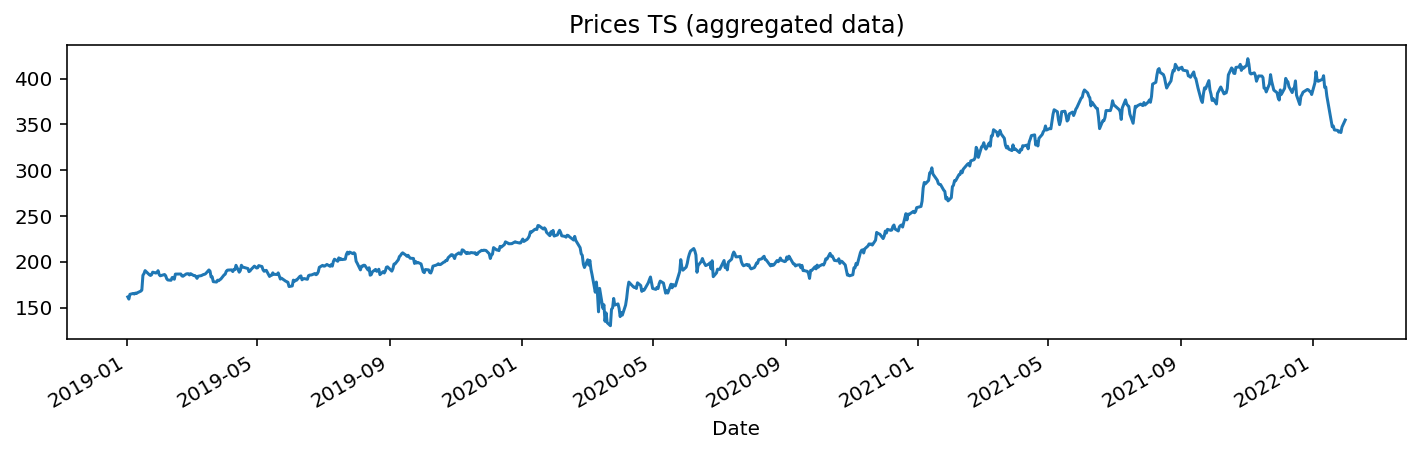

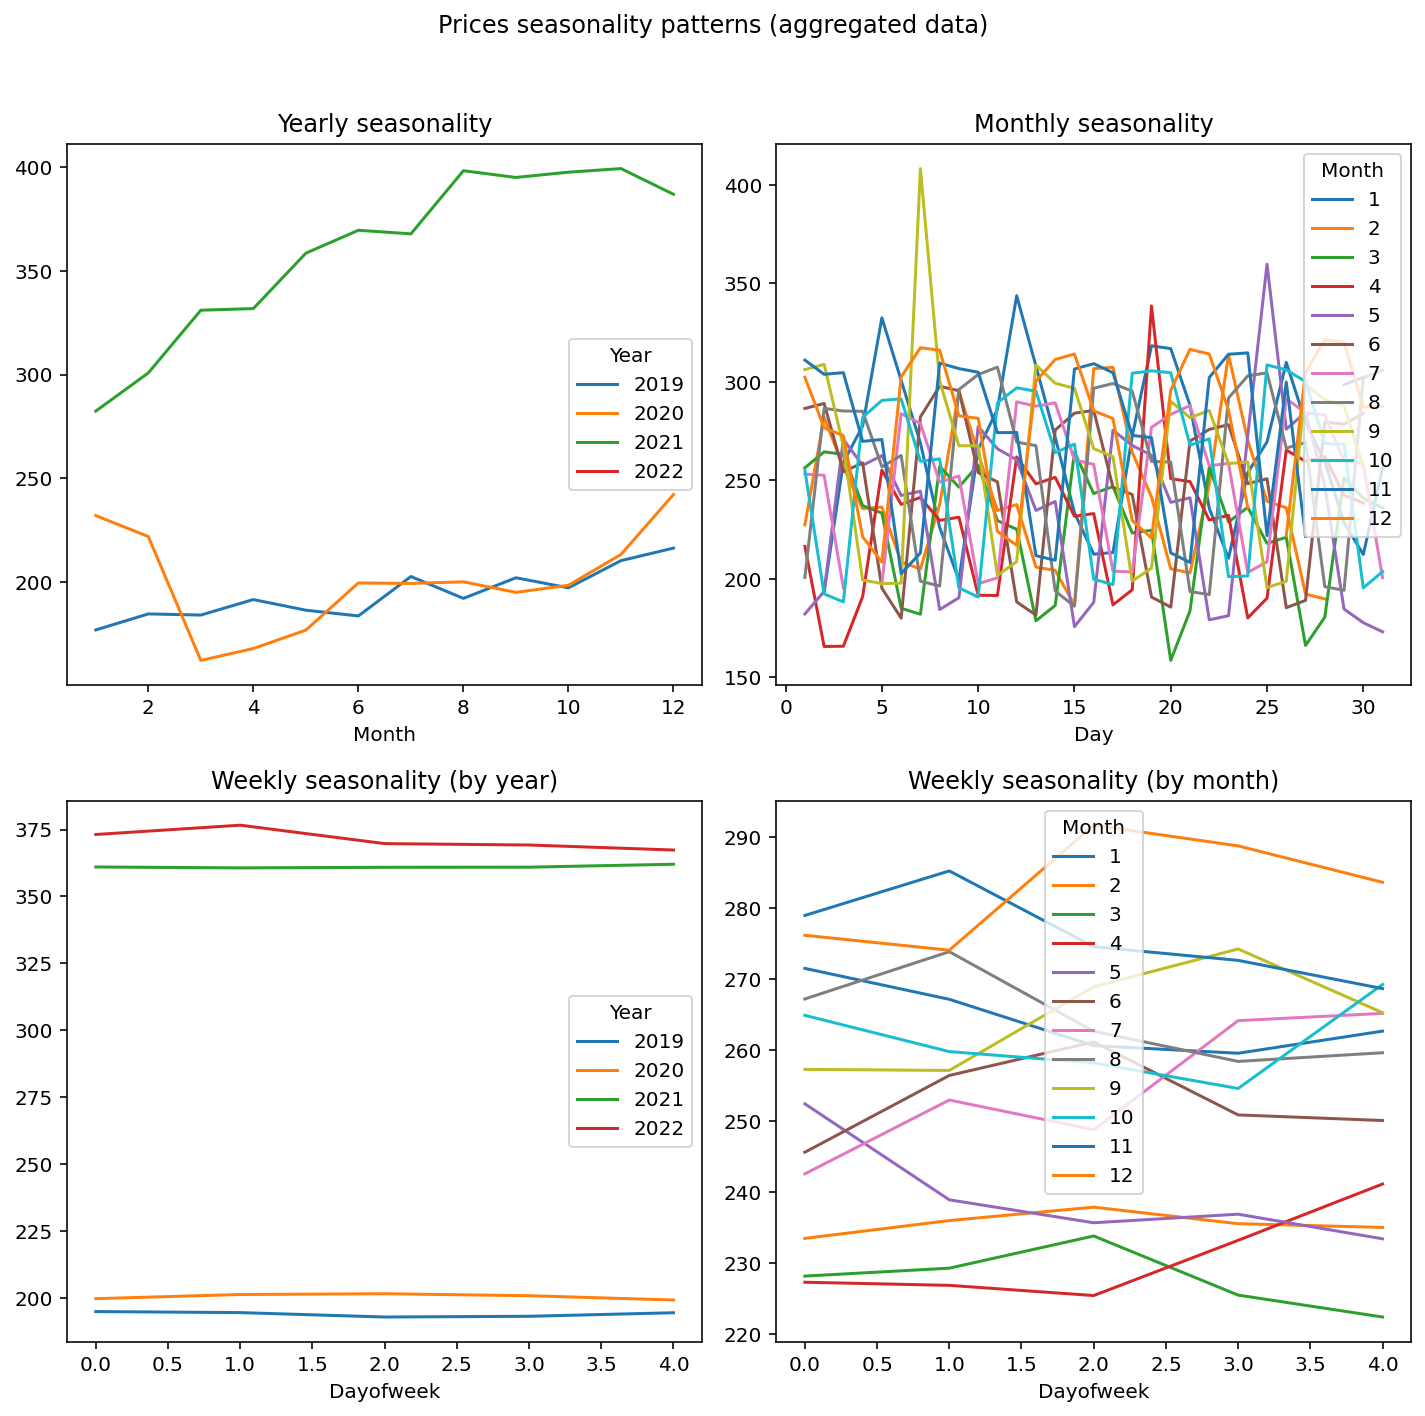

In [21]:
df_trainext=df_trainext.sort_values(by='Date')
a=df_trainext.groupby('Date').mean()['Prices'].plot(figsize=(12,3), title='Prices TS (aggregated data)')

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
_ = pd.pivot_table(df_trainext, values='Prices', columns='Year', index='Month').plot(title="Yearly seasonality", ax=ax[0,0])
_ = pd.pivot_table(df_trainext, values='Prices', columns='Month', index='Day').plot(title="Monthly seasonality", ax=ax[0,1])
_ = pd.pivot_table(df_trainext, values='Prices', columns='Year', index='Dayofweek').plot(title="Weekly seasonality (by year)", ax=ax[1,0])
_ = pd.pivot_table(df_trainext, values='Prices', columns='Month', index='Dayofweek').plot(title="Weekly seasonality (by month)", ax=ax[1,1])
fig.suptitle('Prices seasonality patterns (aggregated data)')
fig.tight_layout(rect=[0, 0, 1, 0.96])

# Modelling

## Baseline

I built a baseline using ARIMA, since its a good statistical to go to model for time series. 

An autoregressive integrated moving average (ARIMA) model is a generalization of an autoregressive moving average (ARMA) model. Both of these models are fitted to time series data either to better understand the data or to predict future points in the series (forecasting). ARIMA models are applied in some cases where data show evidence of non-stationarity, where an initial differencing step (corresponding to the "integrated" part of the model) can be applied one or more times to eliminate the non-stationarity. ARIMA model is of the form: ARIMA(p,d,q): p is AR parameter, d is differential parameter, q is MA parameter

I devided the data into 4 windows- the train, and 3 validation sets (from future data)

The results are as below:
    
   1. 4.7% MAPE for window 1
   
   
   2. 5.1% MAPE for window 2
   
   
   3. 5.7% MAPE for window 3
   
The MAPE increases the further we go in the future


### XGBOOST

XGBOOST regressor with date features had the perfomance below:

    1. MAPE of 9.4% for window 1
    
    2. MAPE of 9.2% for window 2
    
    3. MAPE of 12.9% for window 3
    
# Hyper Parameter Tuning

I tuned the XGBOOST regressor using randomized search; the results improved marginally:

    1. MAPE of 8.07% for window 1
    
    2. MAPE of 7.69% for window 2
    
    3. MAPE of 11.94% for window 3

# H2o AutoML Ensembles:

I went ahead to try h2o automl but got worse results:

    1. MAPE of 17.675466462433885 for window 1
    
    2. MAPE of 17.218327973193198 for window 2
    
    3. MAPE of 17.513003431351507 for window 3

In [1]:
from pandas_datareader import data
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from datetime import date
from datetime import datetime
from datetime import timedelta
from tsfresh.transformers import RelevantFeatureAugmenter
from sklearn.pipeline import Pipeline
import h2o
from h2o.automl import H2OAutoML
import math
import numpy as np
from pmdarima.arima import auto_arima

In [5]:
#checking how the library works and parameters required
data.DataReader?

In [6]:
pd.DataFrame(data.DataReader(['GS'],'yahoo','2019-01-01','2022-01-31'))


Attributes   Adj Close       Close        High         Low        Open  \
Symbols             GS          GS          GS          GS          GS   
Date                                                                     
2019-01-02  161.751465  172.029999  172.250000  163.350006  164.330002   
2019-01-03  159.382019  169.509995  171.770004  168.289993  170.660004   
2019-01-04  164.591034  175.050003  176.000000  171.100006  172.990005   
2019-01-07  165.503052  176.020004  177.830002  172.270004  175.229996   
2019-01-08  164.891922  175.369995  178.100006  172.899994  177.779999   
...                ...         ...         ...         ...         ...   
2022-01-25  341.549988  341.549988  342.929993  330.910004  337.859985   
2022-01-26  342.679993  342.679993  350.480011  338.410004  346.600006   
2022-01-27  341.029999  341.029999  348.769989  337.720001  345.670013   
2022-01-28  347.010010  347.010010  347.149994  333.450012  337.730011   
2022-01-31  354.679993  354.679993  355.209991  343.440002  344.600006   

Attributes     Volume  
Symbols            GS  
Date                   
2019-01-02  3999400.0  
2019-01-03  4060200.0  
2019-01-04  3788300.0  
2019-01-07  3152100.0  
2019-01-08  2692700.0  
...               ...  
2022-01-25  3959300.0  
2022-01-26  3745900.0  
2022-01-27  2573400.0  
2022-01-28  3714600.0  
2022-01-31  3312400.0  

[777 rows x 6 columns]

In [5]:
#sample data frame of adj prices and symbols
gs_aapl_df=pd.DataFrame(pd.DataFrame(data.DataReader(['GS'],'yahoo','2019-01-01','2022-01-31')\
                                        ['Adj Close']).stack())
gs_aapl_df.head()

0
Date       Symbols            
2019-01-02 GS       161.751450
2019-01-03 GS       159.382019
2019-01-04 GS       164.591034
2019-01-07 GS       165.503082
2019-01-08 GS       164.891922

In [7]:
#reset the index and sort values
gs_aapl_df=gs_aapl_df.reset_index()
gs_aapl_df=gs_aapl_df.sort_values(by=['Symbols','Date'])
gs_aapl_df_clean=gs_aapl_df.rename(columns={0:'Prices'})
gs_aapl_df_clean.head()

Date Symbols      Prices
0 2019-01-02      GS  161.751450
1 2019-01-03      GS  159.382019
2 2019-01-04      GS  164.591034
3 2019-01-07      GS  165.503082
4 2019-01-08      GS  164.891922

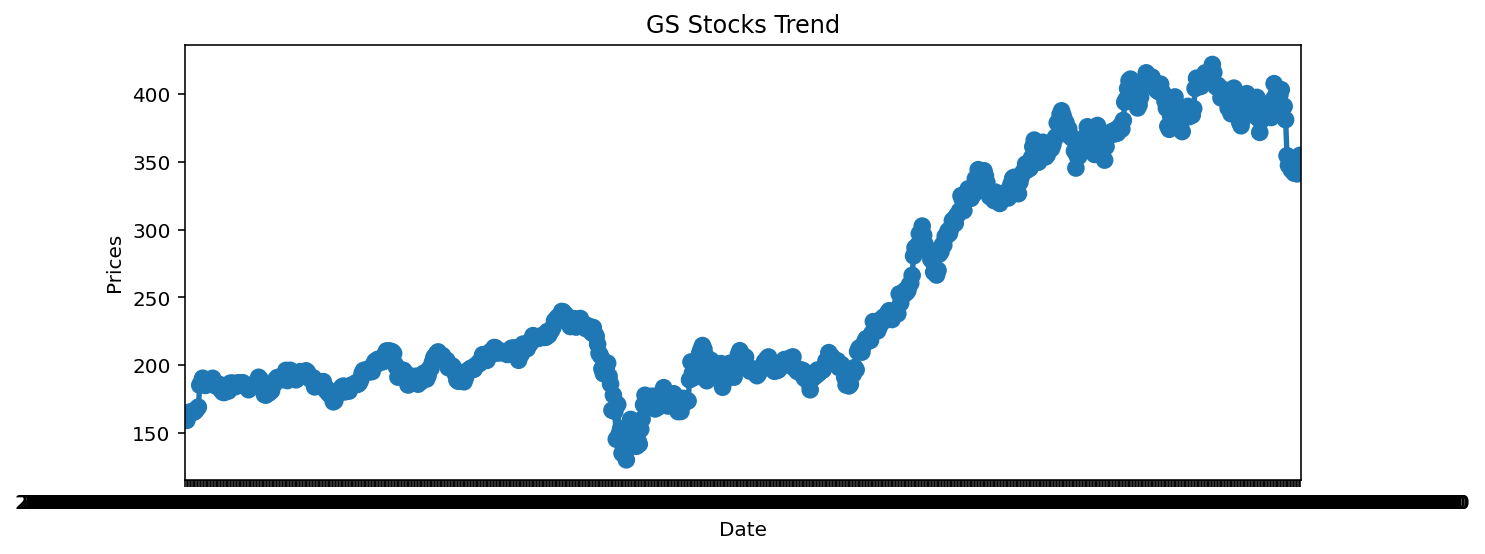

In [8]:
#check trend of teh stock prices
plt.figure(figsize=(10, 4))
plt.title('GS Stocks Trend')

sns.pointplot(gs_aapl_df_clean['Date'].astype('<M8[D]'),y=gs_aapl_df_clean['Prices'])

plt.show();

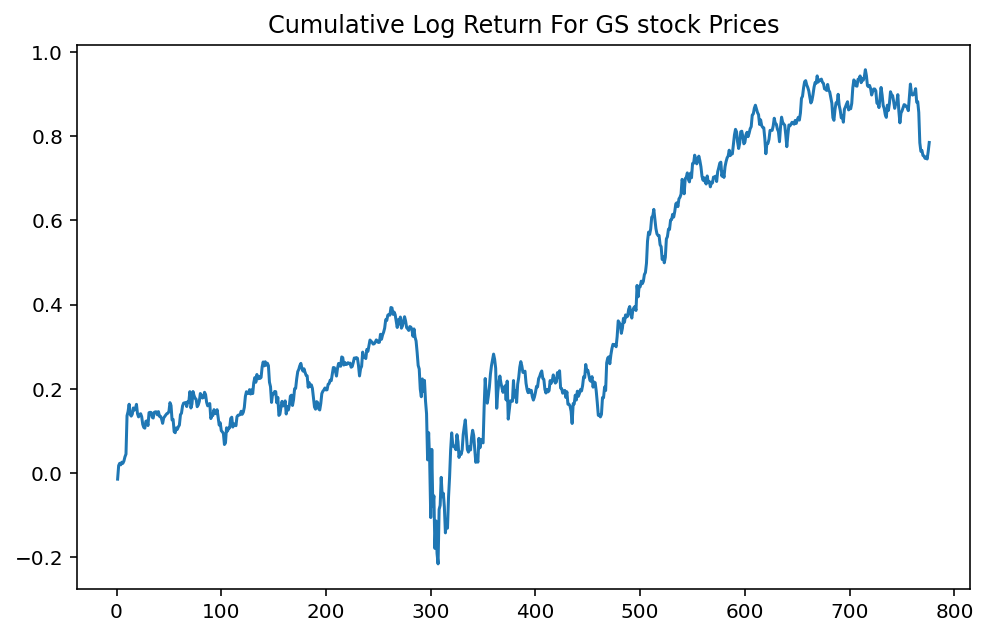

In [16]:
#Using shift(1), we can get the row just above the present row. Here, # lags is 1.
#log() is a function given in numpy package in python. It calculates the natural log of the value given inside it.
gs_aapl_df_clean['cum_Log_Return'] = (np.log(gs_aapl_df_clean['Prices']/gs_aapl_df_clean['Prices'].shift(1))).cumsum()

plt.title('Cumulative Log Return For GS stock Prices')
gs_aapl_df_clean['cum_Log_Return'].plot(figsize=(8,5))
plt.show()

# Baseline (ARIMA)

An autoregressive integrated moving average (ARIMA) model is a generalization of an autoregressive moving average (ARMA) model. Both of these models are fitted to time series data either to better understand the data or to predict future points in the series (forecasting). ARIMA models are applied in some cases where data show evidence of non-stationarity, where an initial differencing step (corresponding to the "integrated" part of the model) can be applied one or more times to eliminate the non-stationarity. ARIMA model is of the form: ARIMA(p,d,q): p is AR parameter, d is differential parameter, q is MA parameter

In [123]:
from pmdarima.arima import auto_arima
#train data - before 2021_08-01
train_df=gs_aapl_df_clean[gs_aapl_df_clean['Date']<'2021-08-01']

# we will test on 3 windows:
test_df1=gs_aapl_df_clean[(gs_aapl_df_clean['Date']>='2021-08-01')&(gs_aapl_df_clean['Date']<'2021-09-30')]

test_df2=gs_aapl_df_clean[(gs_aapl_df_clean['Date']>='2021-09-30')&(gs_aapl_df_clean['Date']<'2021-10-31')]

test_df3=gs_aapl_df_clean[(gs_aapl_df_clean['Date']>='2021-10-31')]

print(test_df1.shape[0])
print(test_df2.shape[0])
print(test_df3.shape[0])

42
22
63


In [124]:
#train model
model_arima=auto_arima(train_df.Prices)
#reset index for later assigning predicted values via index
test_df1=test_df1.reset_index()
test_df1['autoarima']=pd.DataFrame(model_arima.predict(n_periods=42))

test_df1['mape2']=abs(test_df1['Prices']-test_df1['autoarima'])/test_df1['Prices']
print('MAPE of {} for window 1'.format((test_df1['mape2'].mean())*100))


test_df2=test_df2.reset_index()
test_df2['autoarima']=pd.DataFrame(model_arima.predict(n_periods=22))

test_df2['mape2']=abs(test_df2['Prices']-test_df2['autoarima'])/test_df2['Prices']
print('MAPE of {} for window 1'.format((test_df2['mape2'].mean())*100))


test_df3=test_df3.reset_index()
test_df3['autoarima']=pd.DataFrame(model_arima.predict(n_periods=63))

test_df3['mape2']=abs(test_df3['Prices']-test_df3['autoarima'])/test_df3['Prices']
print('MAPE of {} for window 1'.format((test_df3['mape2'].mean())*100))

MAPE of 4.725176326929537 for window 1
MAPE of 5.327075406688515 for window 1
MAPE of 5.150266477066516 for window 1


In [125]:
#Can we beat this baseline with XGBOOST and then autoML model?
# lets first create date features for regression
def create_time_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = pd.to_datetime(df['Date'])
#     df['hour'] = df['date'].dt.hour
    df['dayofweek'] = np.where(df['date'].dt.dayofweek<5,1,0)
    df['dayofweek1'] = df['date'].dt.dayofweek
#     df['year_start']=df['date'].dt.is_year_start
#     df['q_start']=df['date'].dt.is_quarter_start
#     df['m_start']=df['date'].dt.is_month_start
#     df['m_end']=df['date'].dt.is_month_end
    df['norms']=2*np.pi*df['dayofweek1']/df['dayofweek1'].max()
#     df['day_sin'] = np.sin(2 * np.pi * df['date'].dt.dayofweek/7)
#     df['day_cos'] = np.cos(2 * np.pi * df['date'].dt.dayofweek/7)
#     df['mnth_sin'] = np.sin(2 * np.pi * df['date'].dt.day/30.25)
#     df['mnth_cos'] = np.cos(2 * np.pi * df['date'].dt.day/30.25)
#     df['corona_start']=np.where(df['date']>pd.to_datetime('2020-03-01'),1,0)
#     df['cosday']==np.cos(df['norms'])
#     df['sinday']==np.sin(df['norms'])
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['end']=df['date'].dt.is_month_end
    df['weekofmonth']=(df['date'].dt.day-1)//7+1

    X = df
    return X

# XGBOOST with DATE Features

In [136]:
#XGBOOST
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

#create features
train_df2=create_time_features(train_df.drop(['cum_Log_Return','Log Return','Symbols'],1))
X = train_df2.drop(['Prices','Date','date'],1)
y = train_df2["Prices"]

model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

model.fit(X=X, y=y)


test_df11=create_time_features(test_df1.drop(['cum_Log_Return','Log Return','autoarima','mape2','Symbols','index'],1))
test_df22=create_time_features(test_df2.drop(['cum_Log_Return','Log Return','autoarima','mape2','Symbols','index'],1))
test_df33=create_time_features(test_df3.drop(['cum_Log_Return','Log Return','autoarima','mape2','Symbols','index'],1))


test_df11['xgboost']=model.predict(test_df11.drop(['Prices','Date','date'],1))
test_df22['xgboost']=model.predict(test_df22.drop(['Prices','Date','date'],1))
test_df33['xgboost']=model.predict(test_df33.drop(['Prices','Date','date'],1))

test_df11['mape']=abs(test_df11['Prices']-test_df11['xgboost'])/test_df1['Prices']
print('MAPE of {} for window 1'.format((test_df11['mape'].mean())*100))

test_df22['mape']=abs(test_df22['Prices']-test_df22['xgboost'])/test_df22['Prices']
print('MAPE of {} for window 2'.format((test_df22['mape'].mean())*100))

test_df33['mape']=abs(test_df33['Prices']-test_df33['xgboost'])/test_df33['Prices']
print('MAPE of {} for window 3'.format((test_df33['mape'].mean())*100))

<ipython-input-125-84aa135beee5>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


Mean MAE: 5.612 (0.341)
MAPE of 9.45871382127122 for window 1
MAPE of 9.156529332854491 for window 2
MAPE of 12.86911466997071 for window 3


<ipython-input-125-84aa135beee5>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
<ipython-input-125-84aa135beee5>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
<ipython-input-125-84aa135beee5>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


# XGBOOST Hyper Parameter Tuning

In [138]:
from sklearn.model_selection import RandomizedSearchCV
import time
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster = ['gbtree', 'gblinear']
base_score = [0.25, 0.5, 0.75, 1]
learning_rate = [0.05, 0.1, 0.15, 0.20]
min_child_weight = [1, 2, 3, 4]

# Define the grid of hyperparameters to search
params = {
    'n_estimators':[500],
    'min_child_weight':[4,5], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
}
reg = XGBRegressor(nthread=-1)
# run randomized search
n_iter_search = 100
random_search = RandomizedSearchCV(reg, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, scoring='neg_mean_squared_error')

start = time.time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))



[01:43:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:43:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:43:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.



[01:43:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:43:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:43:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.



[01:43:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:43:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:43:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.



[01:43:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:43:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:43:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.



[01:43:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:43:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:43:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.



[01:43:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:43:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:43:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.



[01:43:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:43:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:43:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.



[01:44:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:44:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:44:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.



[01:44:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:44:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:44:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.



[01:44:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:44:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:44:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.



[01:44:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:44:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:44:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.



[01:44:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:44:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:44:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.



[01:45:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:45:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:45:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.



In [139]:
best_regressor = random_search.best_estimator_
test_df11['xgboost2']=best_regressor.predict(test_df11.drop(['Prices','Date','date','xgboost','mape'],1))
test_df22['xgboost2']=best_regressor.predict(test_df22.drop(['Prices','Date','date','xgboost','mape'],1))
test_df33['xgboost2']=best_regressor.predict(test_df33.drop(['Prices','Date','date','xgboost','mape'],1))

test_df11['mape2']=abs(test_df11['Prices']-test_df11['xgboost2'])/test_df1['Prices']
print('MAPE of {} for window 1'.format((test_df11['mape2'].mean())*100))

test_df22['mape2']=abs(test_df22['Prices']-test_df22['xgboost2'])/test_df22['Prices']
print('MAPE of {} for window 2'.format((test_df22['mape2'].mean())*100))

test_df33['mape2']=abs(test_df33['Prices']-test_df33['xgboost2'])/test_df33['Prices']
print('MAPE of {} for window 3'.format((test_df33['mape2'].mean())*100))

MAPE of 8.502550672220417 for window 1
MAPE of 8.394347616803886 for window 2
MAPE of 12.156475890350972 for window 3


# H2o AutoML

In [140]:
h2o.init(port=54321,max_mem_size_GB=16,nthreads=10)

X2=h2o.H2OFrame(train_df2.drop(['Date','date'],1))
x_train = X2.columns
y_train = 'Prices'
x_train=x_train.remove('Prices')


# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=50, seed=1)
aml.train(x=x_train, y=y_train, training_frame=X2)


test_df11['h2o']=aml.leader.predict(h2o.H2OFrame(test_df11.drop(['Prices','Date','date','xgboost','mape'],1))).as_data_frame()
test_df22['h2o']=aml.leader.predict(h2o.H2OFrame(test_df22.drop(['Prices','Date','date','xgboost','mape'],1))).as_data_frame()
test_df33['h2o']=aml.leader.predict(h2o.H2OFrame(test_df33.drop(['Prices','Date','date','xgboost','mape'],1))).as_data_frame()

test_df11['mape3']=abs(test_df11['Prices']-test_df11['h2o'])/test_df1['Prices']
print('MAPE of {} for window 1'.format((test_df11['mape3'].mean())*100))

test_df22['mape3']=abs(test_df22['Prices']-test_df22['h2o'])/test_df22['Prices']
print('MAPE of {} for window 2'.format((test_df22['mape3'].mean())*100))

test_df33['mape3']=abs(test_df33['Prices']-test_df33['h2o'])/test_df33['Prices']
print('MAPE of {} for window 3'.format((test_df33['mape3'].mean())*100))

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ----------------------------------------------------------------------------
H2O_cluster_uptime:         1 hour 48 mins
H2O_cluster_timezone:       Africa/Nairobi
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.36.0.2
H2O_cluster_version_age:    15 days
H2O_cluster_name:           H2O_from_python_hmwangila_xymug0
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    14.06 Gb
H2O_cluster_total_cores:    4
H2O_cluster_allowed_cores:  4
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, Infogram, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.8.7 final
--------------------------  ----------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
01:46:16.408: _train param, Dropping bad and constant columns: [dayofweek]


01:46:18.416: _train param, Dropping bad and constant columns: [dayofweek]

█
01:46:19.422: _train param, Dropping bad and constant columns: [dayofweek]

█
01:46:20.427: _train param, Dropping unused columns: [dayofweek]

█
01:46:21.432: _train param, Dropping bad and constant columns: [dayofweek]


01:46:22.436: _train param, Dropping bad and constant columns: [dayofweek]

███
01:46:25.448: _train param, Dropping bad and constant columns: [dayofweek]

█
01:46:27.458: _train param, Dropping bad and constant columns: [dayofweek]

█
01:46:29.468: _train param, Dropping bad and constant columns: [dayofweek]

█
01:46:31.479: _train param, Dropping unused columns: [dayofweek]

█
01:46:32.485: _train param, Dropping unused columns: [dayofweek]
01:46:33.509: _train param, Dropping bad and constant columns

H2OJobCancelled: Job<$03017f00000132d4ffffffff$_acc7136c215def8b4358ef8fb29649ba> was cancelled by the user.

In [71]:
#build a function to pick data given ticker, start and end date
def stock_picker(tickers:list,data_source,start_date:str,end_date:str):
    '''INPUT
    ticker: a list of tickers of interest
    start_date: first date
    end_date: last date of interest
    
    OUTPUT
    price_df: a dataframe with ticker, date and final adj price'''
    price_df=data.DataReader(tickers,data_source,start_date,end_date)
    #stack the symbols
    prices_stacked_df=price_df['Adj Close'].stack()
    
    #reset the index and sort values
    prices_stacked_df=prices_stacked_df.reset_index()
    prices_stacked_df=prices_stacked_df.sort_values(by=['Symbols','Date'])
    prices_stacked_df_clean=prices_stacked_df.rename(columns={0:'Prices'})

    return prices_stacked_df_clean

In [72]:
stocks_df=stock_picker(['GS','AAPL'],'yahoo','2021-01-01','2021-01-31')


In [10]:
stocks_df.head()

Date Symbols      Prices
1 2021-01-04    AAPL  128.453445
3 2021-01-05    AAPL  130.041611
5 2021-01-06    AAPL  125.664207
7 2021-01-07    AAPL  129.952271
9 2021-01-08    AAPL  131.073929

In [13]:
stocks_df.head()

Date Symbols      Prices
1 2021-01-04    AAPL  128.453445
3 2021-01-05    AAPL  130.041611
5 2021-01-06    AAPL  125.664207
7 2021-01-07    AAPL  129.952271
9 2021-01-08    AAPL  131.073929

In [14]:
def feat_eng(df):
    '''This is a tsfresh function to pivot the data and create aggregates with tsfresh and pick relevant ones
    INPUT:
    stocks_df: a dataframe with prices 
    
    OUTPUT:
    train_model_df: output dataframe with date features'''

    train_model_df=create_time_features(df.sort_values(by=['Symbols','Date'])).drop(['Date','date'],1)
    train_model_df=train_model_df.rename(columns={'Prices':'y'})

    return train_model_df

In [15]:
train_features=feat_eng(stocks_df)
train_features.head()

<ipython-input-12-0a40efbcd0cb>:19: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


Symbols           y  dayofweek  dayofweek1     norms  quarter  month  year  \
1    AAPL  128.453445          1           0  0.000000        1      1  2021   
3    AAPL  130.041611          1           1  1.570796        1      1  2021   
5    AAPL  125.664207          1           2  3.141593        1      1  2021   
7    AAPL  129.952271          1           3  4.712389        1      1  2021   
9    AAPL  131.073929          1           4  6.283185        1      1  2021   

   dayofyear   sin_day   cos_day  dayofmonth  weekofyear    end  weekofmonth  
1          4 -0.756802 -0.653644           4           1  False            1  
3          5 -0.958924  0.283662           5           1  False            1  
5          6 -0.279415  0.960170           6           1  False            1  
7          7  0.656987  0.753902           7           1  False            1  
9          8  0.989358 -0.145500           8           1  False            2

In [ ]:
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

In [142]:
from pmdarima.arima import auto_arima

validation_period=7

def models_training(stocks_df,validation_period:int):
    '''INPUT:
    train_features: dataframe with training features, all symbols and label
    validation_period: validation period as int
    
    OUTPUT:
    
    models: list of best models per symbol
    symbols: list of symbols
    test_df: dataframe with test predictions'''
    global models
    global symbols
    global test_df
    models=[]
    symbols=[]
    test_df=[]
    for i in stocks_df['Symbols'].unique():

        train1=stocks_df[stocks_df['Symbols']==i].drop('Symbols',1)
    #     n=train1.shape[0]
    #     test_cut=math.ceil(n*0.3)
        train=train1.iloc[:-validation_period]
        test=train1.iloc[-validation_period:]
        train2 = train
        test2 = test


        model_arima=auto_arima(train2.Prices)

        
        predicts=pd.DataFrame(model_arima.predict(n_periods=validation_period))
        test=test.reset_index()
        test['pred']=predicts

        models.append(validation_period)
    
        test_df.append(test)
        symbols.append(i)

        
    return models,symbols,test_df


In [144]:
models,symbols,test_df=models_training(stocks_df,7)

In [145]:
len(models)

2

In [146]:
symbols

['AAPL', 'GS']

In [169]:

def prediction(symbols, target_date):

    """INPUT: models: a list of trained models
    symbols: a list of tickers to predict
    target_date: a date you need predicted
    
    OUTPUT:
    predictions"""
    df= pd.DataFrame(
          {'Date' : target_date
          }
        )
    feats=stock_picker(['GS','AAPL'],'yahoo',df['Date'].min()-timedelta(days=400),df['Date'].min()-timedelta(days=1))
    feats=feats.sort_values(by='Date')
    
    prices_predictions = pd.DataFrame(columns = ['Date', 'Ticker', 'Prediction'])

    for symbol in (symbols):
        model=auto_arima(feats.Prices)
        prediction = model.predict(n_periods=((pd.to_datetime(df['Date'].max()+timedelta(1))-pd.to_datetime(df['Date'].min())).days))
#         print(prediction)
        predicted_df = pd.DataFrame(
          {'Date' : target_date,
          'Ticker' : symbol,
          'Prediction' : prediction
          }
        )

        prices_predictions = prices_predictions.append(predicted_df, ignore_index = True)

    return prices_predictions


In [170]:
preds=prediction(symbols, pd.date_range(pd.to_datetime('2022-01-01'),pd.to_datetime('2022-01-05'),freq='d'))
preds

Date Ticker  Prediction
0 2022-01-01   AAPL  277.715115
1 2022-01-02   AAPL  289.306405
2 2022-01-03   AAPL  278.075124
3 2022-01-04   AAPL  278.737325
4 2022-01-05   AAPL  277.623545
5 2022-01-01     GS  277.715115
6 2022-01-02     GS  289.306405
7 2022-01-03     GS  278.075124
8 2022-01-04     GS  278.737325
9 2022-01-05     GS  277.623545

In [194]:
import plotly.express as px

fig=px.line(preds,x='Date',y='Prediction',color='Ticker',line_group='Ticker',hover_name='Ticker',title='Price Predictions')
fig.show();

In [192]:
def test_performance(symbols,validation_date):
    '''INPUT test_df with: forecasted: the forecasted column actual: the actual column OUTPUT: mape: mean absolute percentage error'''
    mape_df=pd.DataFrame()
    for i in (7,14,28):
        
        df=stock_picker(symbols,'yahoo',pd.to_datetime(pd.to_datetime(validation_date)\
                                                  -timedelta(400)),pd.to_datetime(validation_date)+timedelta(days=i))

        df2=df
    
        for j in (symbols):
            df3=df2[df2['Symbols']==j]
            df3=df3.reset_index(drop=True)
            df3=df3.sort_values(by='Date')
            df3=df3[pd.to_datetime(df3['Date'])<=pd.to_datetime(df3['Date'].max())-timedelta(7)]
            df4=df3[pd.to_datetime(df3['Date'])>pd.to_datetime(df3['Date'].max())-timedelta(7)].reset_index()
            print(df4)
            model=auto_arima(df3.Prices)
            df4['pred'] = model.predict(n_periods=df4.shape[0])
            df4['period']=i
           
            
            
            error = abs(df4['pred']-df4['Prices'])
            mae = error/df3['Prices']
            mape = (mae*100).mean()
            print('MAPE for {} is {}% on {} days of data from validation date'.format(j,round(mape,3),i))
            print(df4['Symbols'][0])
            mape_df=mape_df.append(pd.DataFrame(
          {'days_from_validation_date' :i,
          'Ticker' : df3['Symbols'][0],
          'MAPE' : mape
          },
      index=[0]
        ))
    return mape_df
    

In [193]:
val=test_performance(symbols,'2022-01-01')
val.to_dict('records')

   index       Date Symbols      Prices
0    271 2021-12-27    AAPL  180.100540
1    272 2021-12-28    AAPL  179.061859
2    273 2021-12-29    AAPL  179.151749
3    274 2021-12-30    AAPL  177.973251
4    275 2021-12-31    AAPL  177.344055
MAPE for AAPL is 1.066% on 7 days of data from validation date
AAPL
   index       Date Symbols      Prices
0    271 2021-12-27      GS  388.040009
1    272 2021-12-28      GS  387.609985
2    273 2021-12-29      GS  386.200012
3    274 2021-12-30      GS  385.519989
4    275 2021-12-31      GS  382.549988
MAPE for GS is 1.258% on 7 days of data from validation date
GS
   index       Date Symbols      Prices
0    276 2022-01-03    AAPL  181.778397
1    277 2022-01-04    AAPL  179.471344
2    278 2022-01-05    AAPL  174.697418
3    279 2022-01-06    AAPL  171.781143
4    280 2022-01-07    AAPL  171.950928
MAPE for AAPL is 3.544% on 14 days of data from validation date
AAPL
   index       Date Symbols      Prices
0    276 2022-01-03      GS  395.329987

[{'days_from_validation_date': 7,
  'Ticker': 'AAPL',
  'MAPE': 1.0663013878101493},
 {'days_from_validation_date': 7, 'Ticker': 'GS', 'MAPE': 1.257886880277988},
 {'days_from_validation_date': 14,
  'Ticker': 'AAPL',
  'MAPE': 3.5443709877830627},
 {'days_from_validation_date': 14, 'Ticker': 'GS', 'MAPE': 2.2823171730964225},
 {'days_from_validation_date': 28, 'Ticker': 'AAPL', 'MAPE': 2.83194095923598},
 {'days_from_validation_date': 28, 'Ticker': 'GS', 'MAPE': 2.598683259542715}]

## APP

In [1]:
from dash import Dash, dcc, html, Input, Output, State

In [1]:

from dash_extensions.enrich import Output, Dash, Trigger

/usr/local/lib/python3.8/site-packages/dash_extensions/enrich.py:8: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [17]:

from sklearn.ensemble import Weight_Boosting

ImportError: cannot import name 'Weight_Boosting' from 'sklearn.ensemble' (/usr/local/lib/python3.8/site-packages/sklearn/ensemble/__init__.py)